## Step 1：特征工程
我们先对现有变量做变换、交互和分段处理，让模型能捕捉更多非线性关系。

特征工程思路
非线性变换
孕周：log(孕周)、孕周²
BMI：BMI²
交互项
孕周 × BMI
年龄 × 孕周
时间变量处理
末次月经 → 距检测天数（如果有日期字段）
分段特征
孕周分成早期、中期、晚期（One-Hot 编码）

In [14]:
import pandas as pd
import numpy as np

# 1. 读取处理后的数据
df = pd.read_csv('data_processed_std.csv')


# 假设 df 是你的原始数据
df['孕周_sq'] = df['检测孕周_周数'] ** 2
df['BMI_sq'] = df['孕妇BMI'] ** 2
df['孕周xBMI'] = df['检测孕周_周数'] * df['孕妇BMI']
df['年龄x孕周'] = df['年龄'] * df['检测孕周_周数']

# 孕周分段
df['孕周阶段'] = pd.cut(df['检测孕周_周数'], bins=[0, 12, 24, 40], labels=['早期', '中期', '晚期'])
df = pd.get_dummies(df, columns=['孕周阶段'], drop_first=True)


Step 2：GAM 建模（可解释性强）
GAM（广义加性模型）能画出每个变量对 Y 浓度的平滑曲线，非常适合写论文时解释生物学意义。

GAM 训练集 R²: 0.4149701069319044
GAM 测试集 R²: 0.3053550232634382


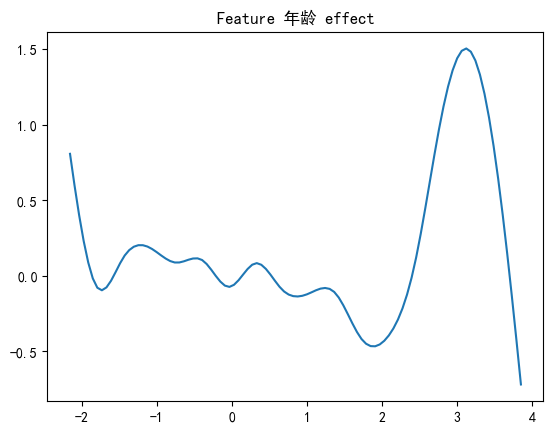

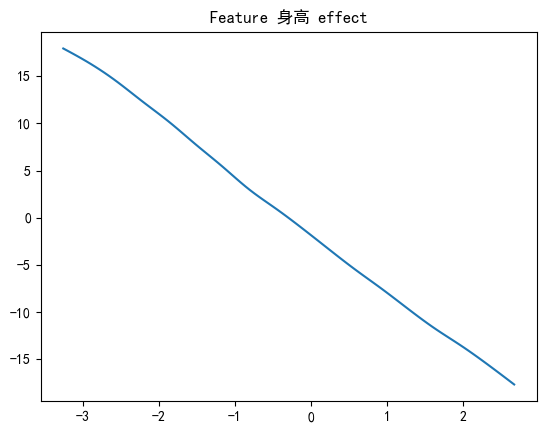

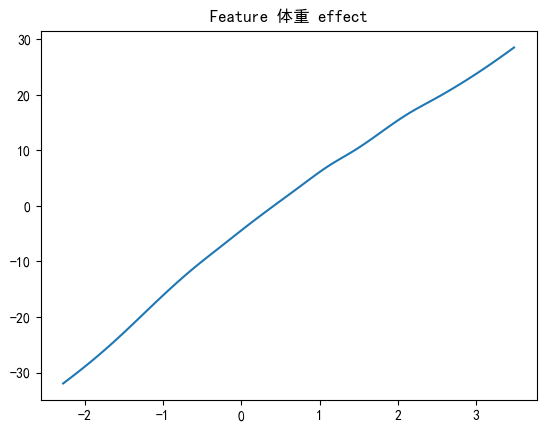

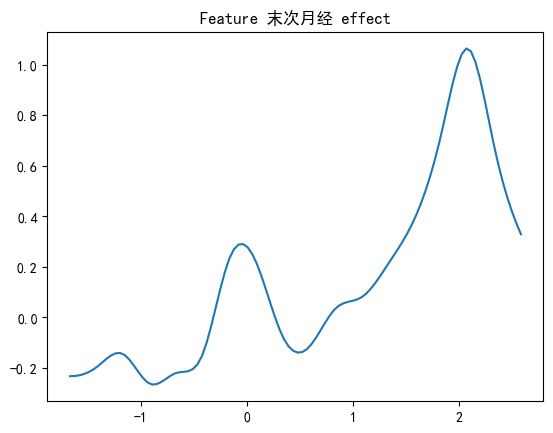

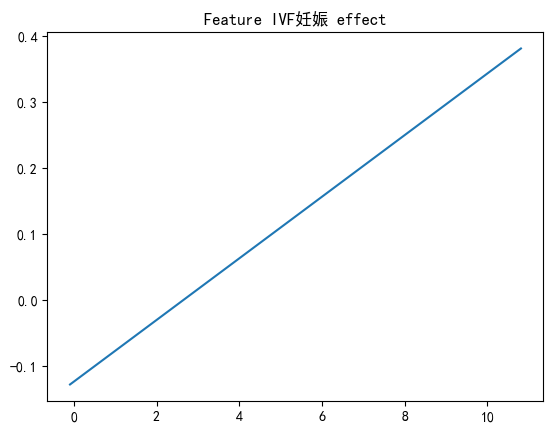

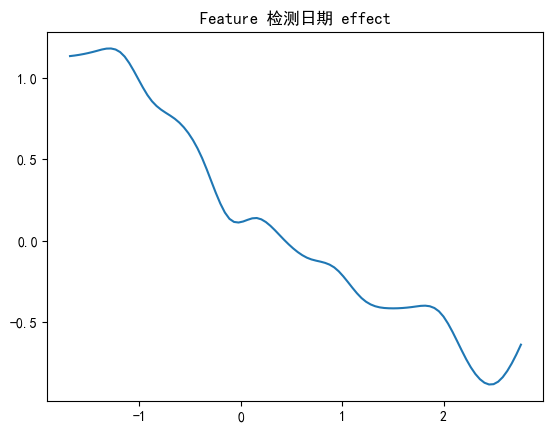

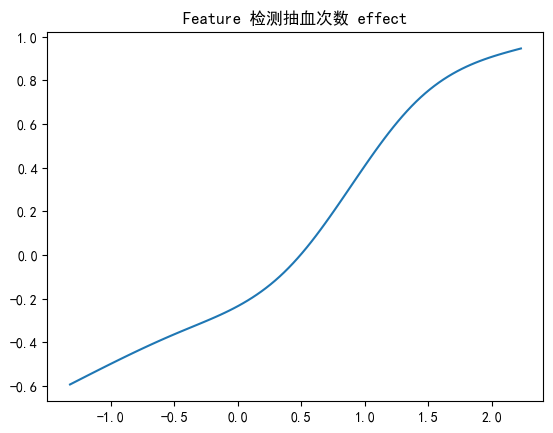

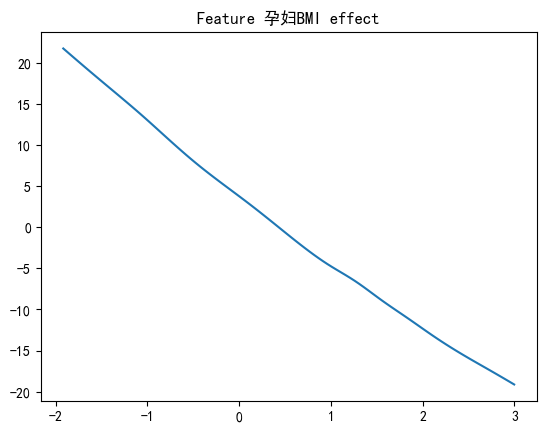

In [15]:
from pygam import LinearGAM, s
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df.drop(columns=['Y染色体浓度'])
y = df['Y染色体浓度']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 对每个特征使用平滑函数 s()
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_train, y_train)

print("GAM 训练集 R²:", r2_score(y_train, gam.predict(X_train)))
print("GAM 测试集 R²:", r2_score(y_test, gam.predict(X_test)))

# 绘制每个特征的影响曲线
import matplotlib.pyplot as plt


# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.figure()
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Feature {X.columns[i]} effect')
    plt.show()


## Step 3：XGBoost（性能提升）
我们用 XGBoost 来捕捉复杂非线性关系，并做简单调参。

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("最佳参数:", grid.best_params_)
print("训练集 R²:", r2_score(y_train, grid.predict(X_train)))
print("测试集 R²:", r2_score(y_test, grid.predict(X_test)))


最佳参数: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
训练集 R²: 0.9995174459730104
测试集 R²: 0.7433044160446669


In [18]:
X_train

,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,孕妇BMI,原始读段数,在参考基因组上比对的比例,...,怀孕次数,生产次数,胎儿是否健康,检测孕周_周数,孕周_sq,BMI_sq,孕周xBMI,年龄x孕周,孕周阶段_中期,孕周阶段_晚期
865,-0.793392,-0.387509,0.219910,-0.985111,-0.092406,-0.931303,1.340970,0.585600,1.076124,0.636960,...,1.454389,-0.600678,0.1918,-0.067054,0.004496,0.342927,-0.039267,0.053200,False,False
616,-0.246578,-0.769836,-0.767410,-0.320591,-0.092406,-0.573550,-1.319422,-0.448304,-0.225201,-0.644179,...,-0.885756,-0.600678,0.1918,-0.990150,0.980397,0.200976,0.443888,0.244149,False,False
2,0.573644,-0.196345,-1.103996,-0.501824,-0.092406,-0.242628,0.454173,-1.273748,-0.886975,0.428180,...,-0.885756,-0.600678,0.1918,0.856042,0.732808,1.622435,-1.090382,0.491064,False,False
101,-0.519985,-1.152164,-1.154994,-0.763604,-0.092406,-0.493055,0.454173,-0.711432,-0.400216,0.490195,...,1.454389,0.963131,0.1918,0.785034,0.616279,0.506136,-0.558499,-0.408206,False,False
332,1.393867,0.950638,0.017958,0.958105,-0.092406,1.143664,0.454173,-0.607693,0.406899,-0.928573,...,0.284317,0.963131,0.1918,-0.209069,0.043710,0.369291,0.127050,-0.291414,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.026830,-0.578673,0.119954,-0.149427,-0.092406,0.133012,0.454173,0.599226,0.024724,-0.704990,...,0.284317,-0.600678,0.1918,1.033560,1.068247,0.359072,0.619336,0.027730,False,False
270,0.573644,-0.769836,-0.798008,-0.411208,-0.092406,-0.180022,0.454173,-0.489388,0.058037,0.431658,...,0.284317,0.963131,0.1918,0.785034,0.616279,0.239500,-0.384186,0.450331,False,False
860,-0.246578,-0.005181,-0.617476,-0.501824,-0.092406,-0.448336,0.454173,-0.770785,-0.179841,-0.219938,...,-0.885756,-0.600678,0.1918,0.145968,0.021307,0.594110,-0.112510,-0.035992,False,False
435,0.026830,-1.152164,-1.409983,1.391049,-0.092406,1.188383,-0.432625,-1.063654,2.029288,0.858055,...,-0.885756,-0.600678,0.1918,-0.209069,0.043710,1.131359,0.222377,-0.005609,False,False
